Assignment 7 - Adult Census Income

This assignment focuses on building and comparing machine learning models to predict whether an individual's income exceeds $50,000 per year based on 1994 Census data. This assignment invovles Data Engineering (cleaning and preparing the data), implementation of  three algorithms: Decision Trees, Random Forests, and XGBoost and Applying concept of Hyperparameter Tuning. The goal is to achieve high accuracy and also to understand why the models make their decisions using SHAP.

PART 1 - Decision Trees – Theory & Implementation

EXPLAINATIONS:
1. Gini Impurity vs Entropy
- Gini Impurity: Gini Impurity tells us that how often our random predictions can go wrong, if gini impurity value is 0 then our prediction can never go wrong and if the group is mixed well enough then our predictions can go wrong and that means our gini impurity value will be High. Gini Impurity is fast to calculate
- Entropy: Entropy measures the How much confusion or messyness is there in one group, if all the values are same in one particular group then the value of entropy will be 0 and if group have high messyness then the value of entropy will be High. Entropy is slow to calculate as compare to Gini Impurity

2. Overfitting in Decision Trees
- This occurs when the model learn the data to precisely means rather then learning the gernal patterns, models memorize the data and due to which model perform execptionally well on training data but performs poorly on the unseen test data. this usually happens when the tree is allowed to grow very deep and continues its splitting of data until very few samples remains in each leaf node due to which models remember that data very well at the end. due to this reasone tree complexity is essential to prevent overfitting

3. Role of max_depth, min_samples_split
- max_depth: It specifies the maximum number of levels the tree is allowed to grow, thereby limiting how many successive splits can be made. A smaller depth produces a simpler tree, while a larger depth allows more complex decision rules.
- min_samples_split: It defines the minimum number of data samples required to split an internal node; if a node contains fewer samples than this value, it will not be split further.
Together these Hyperparameters used to control the complexity of a decision tree and prevent overfitting. 

In [61]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load data with 'auto' parser to handle types correctly
adult = fetch_openml('adult', version=2, as_frame=True, parser='auto')
df = adult.frame

# Shows data types and non-null counts
print("--- Initial Inspection ---")
print(df.info())
print("\nFirst 5 rows:")
display(df.head())

--- Initial Inspection ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None

First 5 rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [62]:
import numpy as np

# We check if '?' exists anywhere in the dataframe
print("Is '?' present in the data?", ('?' in df.values))

# If '?' is found, we replace it with NaN so all missing data is treated the same
df = df.replace('?', np.nan)

# Now we see the true total of missing values
print("\nTrue Missing values per column:")
print(df.isnull().sum())

Is '?' present in the data? False

True Missing values per column:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64


In [63]:
# We use .copy() to ensure we aren't working on a "view" of the data
df_cleaned = df.dropna().copy()

print(f"Original dataset rows: {len(df)}")
print(f"Rows after removing missing data: {len(df_cleaned)}")
print(f"Data retained: {(len(df_cleaned)/len(df)):.2%}")

Original dataset rows: 48842
Rows after removing missing data: 45222
Data retained: 92.59%


In [64]:
import numpy as np

# We apply log1p (log of 1 + x)
# Because log(0) is impossible. log(1+0) = 0.
df_cleaned['capital-gain'] = df_cleaned['capital-gain'].apply(np.log1p)
df_cleaned['capital-loss'] = df_cleaned['capital-loss'].apply(np.log1p)

print("Log Transformation complete. Skewed values have been 'squashed' for better learning.")

Log Transformation complete. Skewed values have been 'squashed' for better learning.


In [65]:
from sklearn.preprocessing import StandardScaler

# We identify the numerical columns that need scaling
num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

scaler = StandardScaler()
df_cleaned[num_cols] = scaler.fit_transform(df_cleaned[num_cols])

print("Scaling complete. All numerical features now have a mean of 0 and a standard deviation of 1.")
display(df_cleaned[num_cols].head())

Scaling complete. All numerical features now have a mean of 0 and a standard deviation of 1.


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-1.024983,0.350889,-1.221559,-0.300328,-0.222752,-0.078120
1,-0.041455,-0.945878,-0.438122,-0.300328,-0.222752,0.754701
2,-0.798015,1.393592,0.737034,-0.300328,-0.222752,-0.078120
3,0.412481,-0.278420,-0.046403,3.327301,-0.222752,-0.078120
5,-0.344079,0.084802,-1.613277,-0.300328,-0.222752,-0.910942


In [66]:
import pandas as pd

# 1. Target: Turn income into 1 (>50K) and 0 (<=50K)
# We strip spaces to ensure the text matches perfectly
df_cleaned['class'] = df_cleaned['class'].astype(str).str.strip()
df_cleaned['target'] = df_cleaned['class'].map({'>50K': 1, '<=50K': 0})

# 2. Selection: Drop text 'education' (redundant with education-num) and old 'class'
df_ml = df_cleaned.drop(columns=['class', 'education'])

# 3. One-Hot Encoding: Create binary columns for categories like Occupation or Race
df_final = pd.get_dummies(df_ml, drop_first=True)
df_final = df_final.astype(float)

print(f"Final dataset ready. Total features: {df_final.shape[1]}")
pd.set_option('display.max_columns', 100)
display(df_final.head())

Final dataset ready. Total features: 83


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,-1.024983,0.350889,-1.221559,-0.300328,-0.222752,-0.078120,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.041455,-0.945878,-0.438122,-0.300328,-0.222752,0.754701,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.798015,1.393592,0.737034,-0.300328,-0.222752,-0.078120,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.412481,-0.278420,-0.046403,3.327301,-0.222752,-0.078120,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,-0.344079,0.084802,-1.613277,-0.300328,-0.222752,-0.910942,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [67]:
from sklearn.model_selection import train_test_split

# Separate Features (X) from Target (y)
X = df_final.drop(columns=['target'])
y = df_final['target']

# Split: 80% for Training, 20% for the Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print(f"Training set: {X_train.shape[0]} rows")
print(f"Testing set: {X_test.shape[0]} rows")

Training set: 36177 rows
Testing set: 9045 rows


In [68]:
from sklearn.tree import DecisionTreeClassifier

# We set max_depth=5 to stop the tree from growing too complex (Memorization/Overfitting)
dt_model = DecisionTreeClassifier(max_depth=5, random_state=5)

# The model 'fits' its logic to the training data
dt_model.fit(X_train, y_train)

print("Decision Tree training complete.")

Decision Tree training complete.


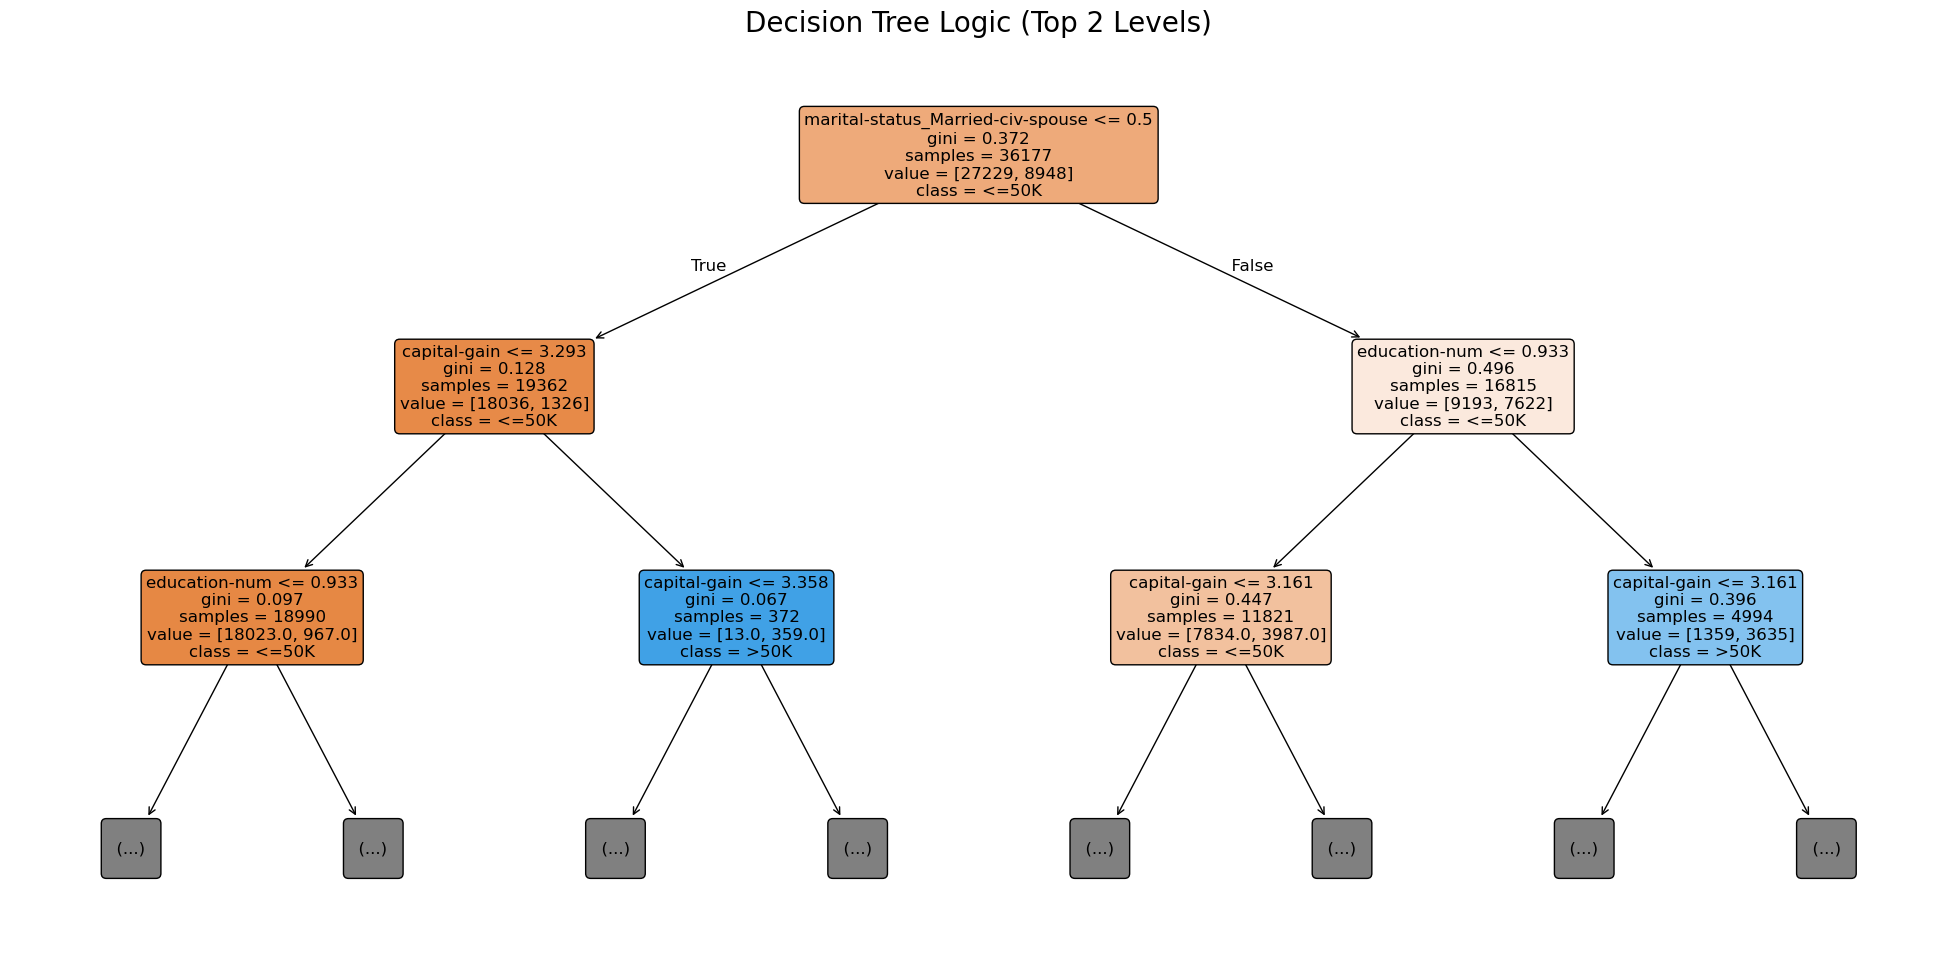

In [69]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Created a large figure so we can see the details
plt.figure(figsize=(25, 12))

# We plot the tree. 
# feature_names=X.columns tells us which questions the tree is asking (e.g., is age > 30?)
# class_names=['<=50K', '>50K'] tells us what the answer is at the end of the branch
# filled=True colors the boxes (Blue for high income, Orange for low income)
plot_tree(dt_model, 
          feature_names=X.columns, 
          class_names=['<=50K', '>50K'], 
          filled=True, 
          rounded=True, 
          fontsize=12,
          max_depth=2)

plt.title("Decision Tree Logic (Top 2 Levels)", fontsize=20)
plt.show()

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Testing Phase
y_pred = dt_model.predict(X_test)

print("--- Decision Tree Results ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.2%}")
print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall:    {recall_score(y_test, y_pred):.2%}")

--- Decision Tree Results ---
Accuracy:  84.43%
Precision: 78.40%
Recall:    52.04%


<Figure size 800x600 with 0 Axes>

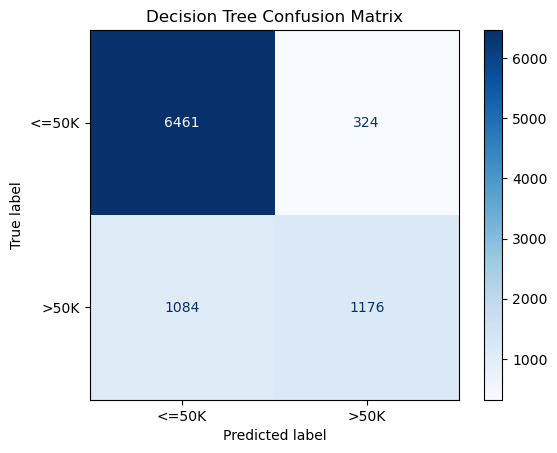

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Create the confusion matrix math
cm = confusion_matrix(y_test, y_pred)

# 2. Display it visually
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Blues', values_format='d')

plt.title("Decision Tree Confusion Matrix")
plt.show()

Part 2 - Random Forests & Ensembles

EXPLANATIONS:
1. Bagging:
It is an ensemble learning technique where multiple models are trained on different random samples of the same dataset, and their predictions are combined to make a final decision. In bagging, data is sampled with replacement, meaning the same data point can appear multiple times in one sample and may not appear in another. Each model learns slightly different patterns because it sees a different version of the data. At the end, all models vote (for classification) or average their results (for regression). Bagging helps reduce errors caused by randomness and makes the overall prediction more stable and reliable than using a single model.

2. Why Random Forests reduce overfitting:
Random Forests reduce overfitting because they do not rely on a single decision tree. Instead, they build many decision trees using bagging and then combine their results. Each tree is trained on a different random sample of data, and at every split, only a random subset of features is considered. This randomness prevents trees from becoming too similar and stops them from memorizing the training data. Since overfitting usually happens when a model learns very specific patterns from one dataset, averaging predictions from many diverse trees smooths out noise and focuses on general patterns, leading to better performance on unseen data.

3. Feature importance:
It tells us how useful each feature is in making predictions in a model like Random Forest. It measures how much a feature helps reduce impurity (such as Gini impurity or entropy) when the model makes splits. If a feature is frequently used to split data and significantly improves prediction quality, it gets a higher importance score. Features that are rarely used or do not improve splits receive lower importance. Feature importance helps us understand which input variables matter most, makes the model more interpretable, and can be used to remove less useful features to simplify the model.

In [72]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators=100 means we are building a 'committee' of 100 trees
# max_depth=10 gives the trees a bit more room to learn than our single tree had
# random_state=5 ensures we get the same 'random' result every time
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=5)

# Training the forest (this might take a second longer than a single tree)
rf_model.fit(X_train, y_train)

print("Random Forest training complete with 100 trees.")

Random Forest training complete with 100 trees.


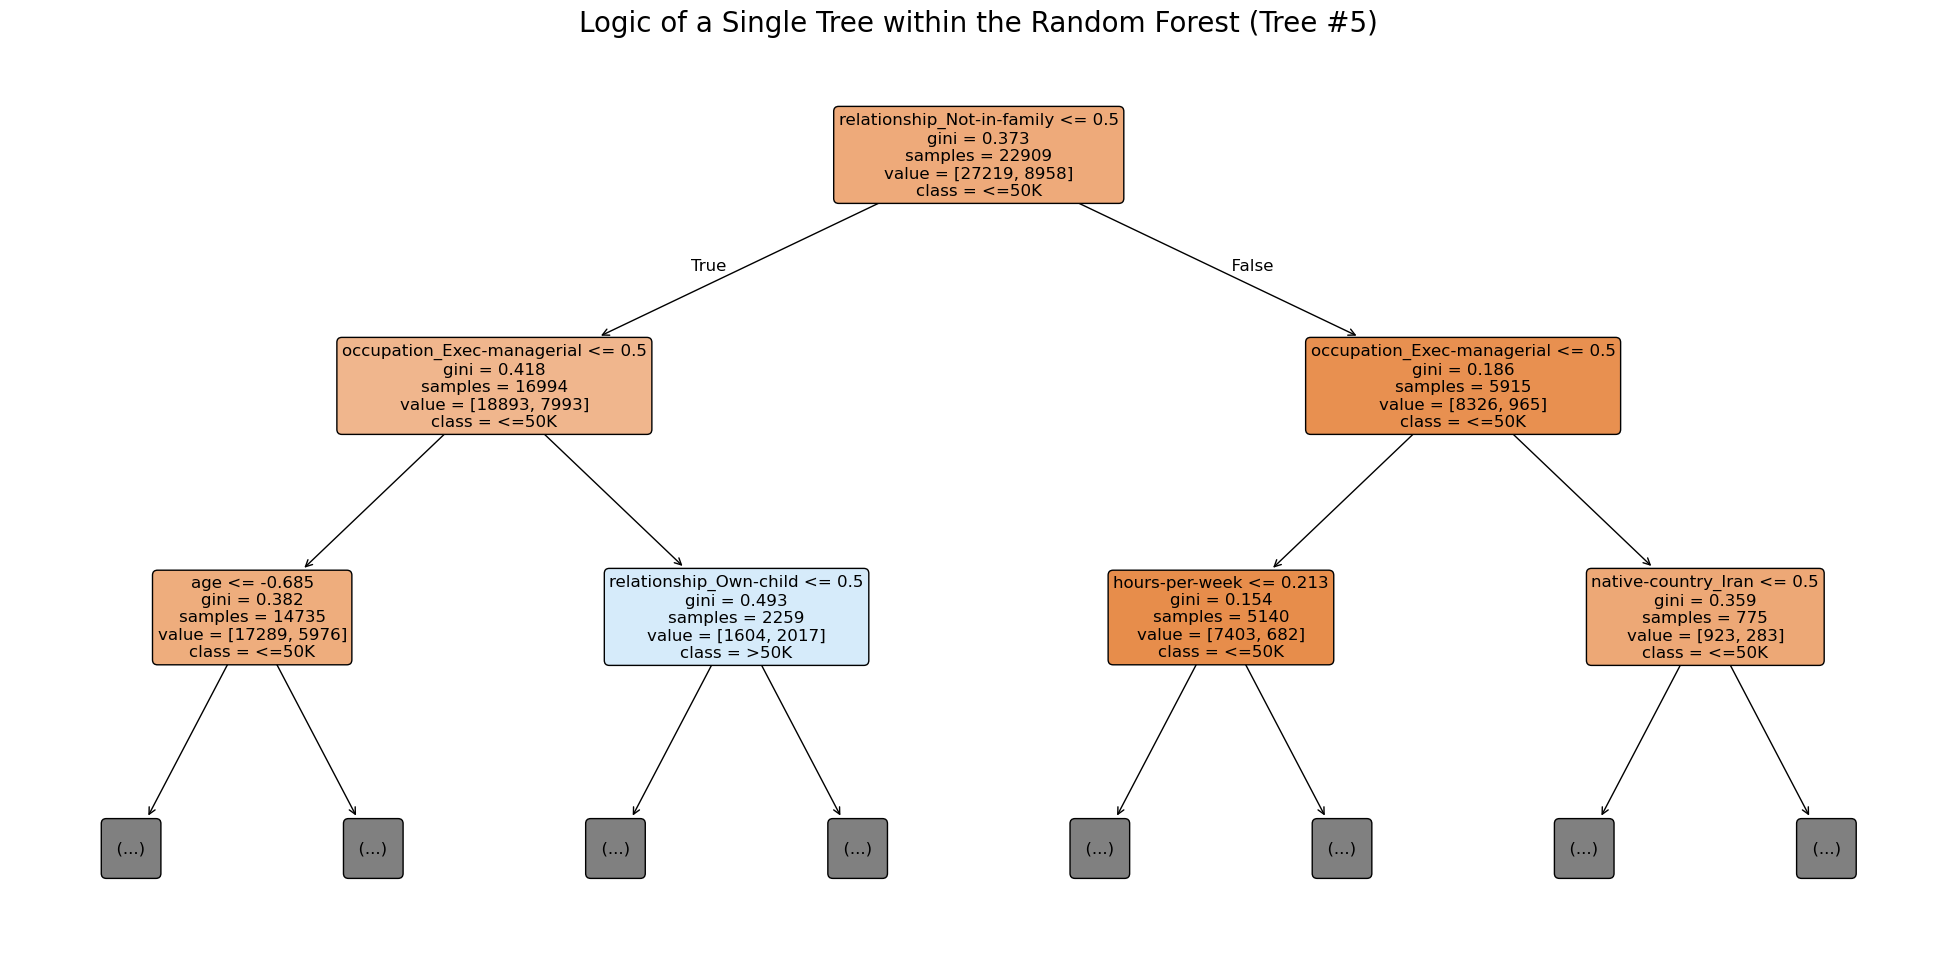

In [73]:
from sklearn.tree import plot_tree

# We pick the 5th tree from our forest of 100
sample_tree = rf_model.estimators_[5]

plt.figure(figsize=(25, 12))
plot_tree(sample_tree, 
          feature_names=X.columns, 
          class_names=['<=50K', '>50K'], 
          filled=True, 
          rounded=True, 
          max_depth=2, 
          fontsize=12)

plt.title("Logic of a Single Tree within the Random Forest (Tree #5)", fontsize=20)
plt.show()

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions from the forest
rf_pred = rf_model.predict(X_test)

print("--- Random Forest Results ---")
print(f"Accuracy:  {accuracy_score(y_test, rf_pred):.2%}")
print(f"Precision: {precision_score(y_test, rf_pred):.2%}")
print(f"Recall:    {recall_score(y_test, rf_pred):.2%}")

# Quick logic check: Let's see the improvement
dt_acc = accuracy_score(y_test, y_pred) # This is from our Cell 9
rf_acc = accuracy_score(y_test, rf_pred)
print(f"\nImprovement in Accuracy: {rf_acc - dt_acc:.2%}")

--- Random Forest Results ---
Accuracy:  85.42%
Precision: 80.73%
Recall:    54.69%

Improvement in Accuracy: 0.98%


<Figure size 800x600 with 0 Axes>

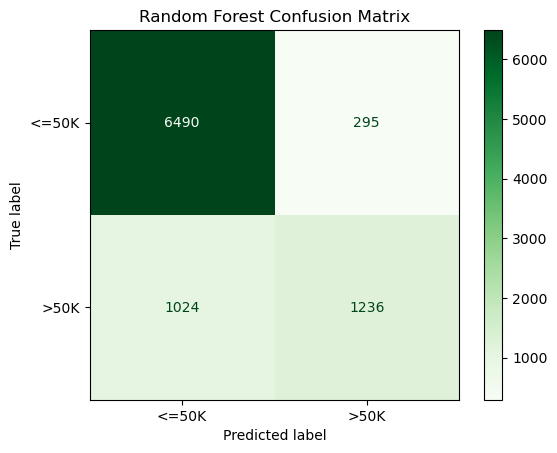

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the math
rf_cm = confusion_matrix(y_test, rf_pred)

# Display it
plt.figure(figsize=(8, 6))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['<=50K', '>50K'])
disp_rf.plot(cmap='Greens', values_format='d')

plt.title("Random Forest Confusion Matrix")
plt.show()

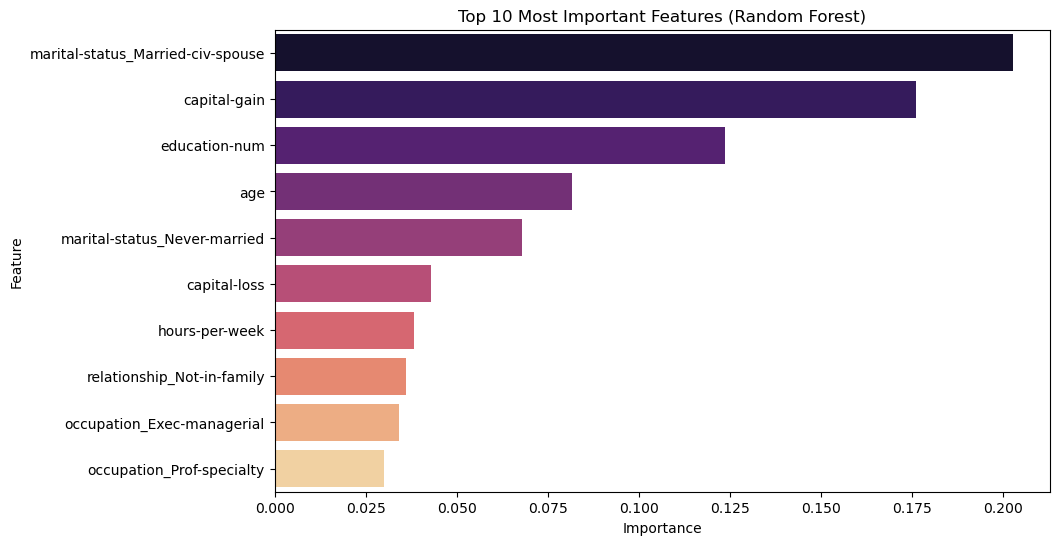

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the importance scores
importances = rf_model.feature_importances_
feature_names = X.columns

# Organize into a DataFrame
feat_import_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_import_df = feat_import_df.sort_values(by='Importance', ascending=False).head(10)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feat_import_df, 
    palette='magma', 
    hue='Feature', 
    legend=False
)
plt.title("Top 10 Most Important Features (Random Forest)")
plt.show()

Part 3 - Gradient Boosting (XGBoost)

EXPLANATIONS:
1. Boosting vs Bagging:
- Boosting: It is an ensemble technique where models are trained sequentially, and each new model focuses on correcting the mistakes of the previous ones. It reduces bias and improves accuracy by gradually strengthening weak learners.
- Bagging: It is an ensemble technique where multiple models are trained independently and in parallel on different random samples of the same dataset. Their predictions are combined using voting or averaging to reduce variance and prevent overfitting.

2. Sequential learning:
This means that models are trained one after another, not at the same time. In this approach, each new model learns from the mistakes of the previous model. Data points that were predicted incorrectly earlier are given more importance so that the next model pays extra attention to them. This helps the overall system gradually improve its performance. Sequential learning is mainly used in boosting techniques, where the goal is to slowly build a strong model by combining many weak models. This step-by-step learning process allows the model to focus on difficult cases that were missed before.

3. Learning rate:
It controls how much influence each new model has when it is added to the overall system in boosting. A small learning rate means the model learns slowly and carefully, making small improvements at each step, which usually leads to better generalization but takes more time. A large learning rate means the model learns quickly by making bigger changes, which can speed up training but may cause overfitting or unstable results. In simple terms, the learning rate decides whether the model should learn slowly and safely or learn fast and aggressively, and choosing the right value is important for good performance.

In [77]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [78]:
import xgboost as xgb

# We initialize the XGBClassifier
# n_estimators=100: We build 100 trees sequentially
# learning_rate=0.1: We learn at a moderate pace to ensure accuracy
# max_depth=5: We keep individual trees simple
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Training
xgb_model.fit(X_train, y_train)

print("XGBoost training complete.")

XGBoost training complete.


In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Predictions
xgb_pred = xgb_model.predict(X_test)

print("--- XGBoost Results ---")
print(f"Accuracy:  {accuracy_score(y_test, xgb_pred):.2%}")
print(f"Precision: {precision_score(y_test, xgb_pred):.2%}")
print(f"Recall:    {recall_score(y_test, xgb_pred):.2%}")

--- XGBoost Results ---
Accuracy:  86.62%
Precision: 79.10%
Recall:    63.14%


<Figure size 800x600 with 0 Axes>

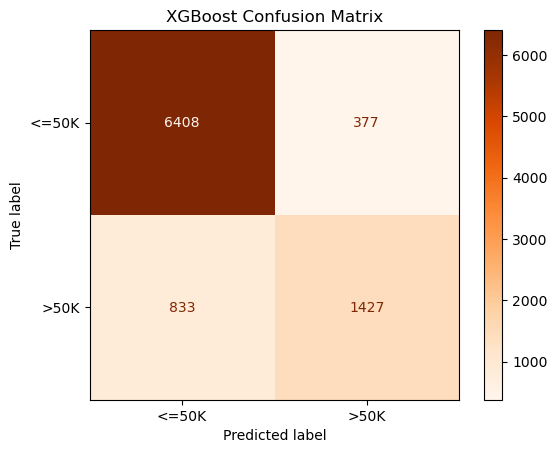

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Create the confusion matrix for XGBoost
xgb_cm = confusion_matrix(y_test, xgb_pred)

# 2. Display it
plt.figure(figsize=(8, 6))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=['<=50K', '>50K'])
disp_xgb.plot(cmap='Oranges', values_format='d')

plt.title("XGBoost Confusion Matrix")
plt.show()

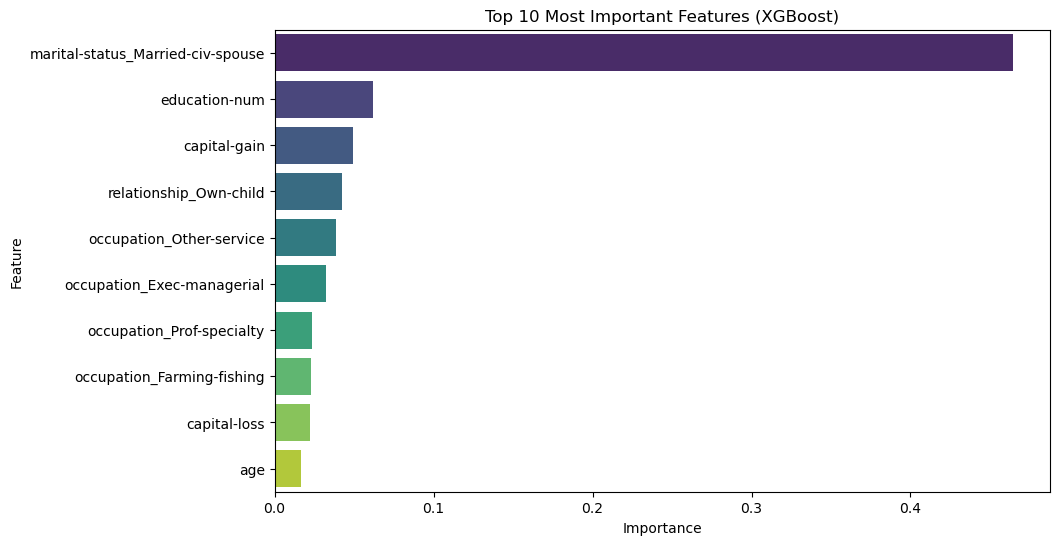

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost has a built-in property for feature importances
xgb_importances = xgb_model.feature_importances_

# Create a DataFrame for visualization
xgb_feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_importances})
xgb_feat_df = xgb_feat_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=xgb_feat_df, 
    palette='viridis', 
    hue='Feature', 
    legend=False
)
plt.title("Top 10 Most Important Features (XGBoost)")
plt.show()

In [82]:
import pandas as pd

# Creating a summary of our journey
results_data = {
    "Model": ["Decision Tree", "Random Forest", "XGBoost"],
    "Accuracy": [accuracy_score(y_test, y_pred), accuracy_score(y_test, rf_pred), accuracy_score(y_test, xgb_pred)],
    "Precision": [precision_score(y_test, y_pred), precision_score(y_test, rf_pred), precision_score(y_test, xgb_pred)],
    "Recall": [recall_score(y_test, y_pred), recall_score(y_test, rf_pred), recall_score(y_test, xgb_pred)]
}

comparison_df = pd.DataFrame(results_data)

# Show the table
print("--- Model Comparison Table ---")
display(comparison_df)

--- Model Comparison Table ---


,Model,Accuracy,Precision,Recall
0,Decision Tree,0.844334,0.784000,0.520354
1,Random Forest,0.854174,0.807315,0.546903
2,XGBoost,0.866224,0.791020,0.631416


Part 4 - Hyperparameter Tuning & Interpretability

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# 1. Define the 'Grid' (The different knob settings we want to try)
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# 2. Initialize the Grid Search
# cv=5 means '5-fold Cross Validation' (testing the model 5 different ways to be sure)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=5), param_grid, cv=5, scoring='accuracy')

# 3. Start the Search
grid_search.fit(X_train, y_train)

# 4. Results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy from Tuning: {grid_search.best_score_:.2%}")

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
Best Accuracy from Tuning: 85.57%


In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# We use the exact 'Best Parameters' the computer found for us
best_dt_model = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=10, 
    min_samples_split=5, 
    random_state=42
)

# Train on our full training set
best_dt_model.fit(X_train, y_train)

# Test it
best_pred = best_dt_model.predict(X_test)

print("--- Refined Decision Tree Results ---")
print(f"New Accuracy: {accuracy_score(y_test, best_pred):.2%}")

--- Refined Decision Tree Results ---
New Accuracy: 85.14%


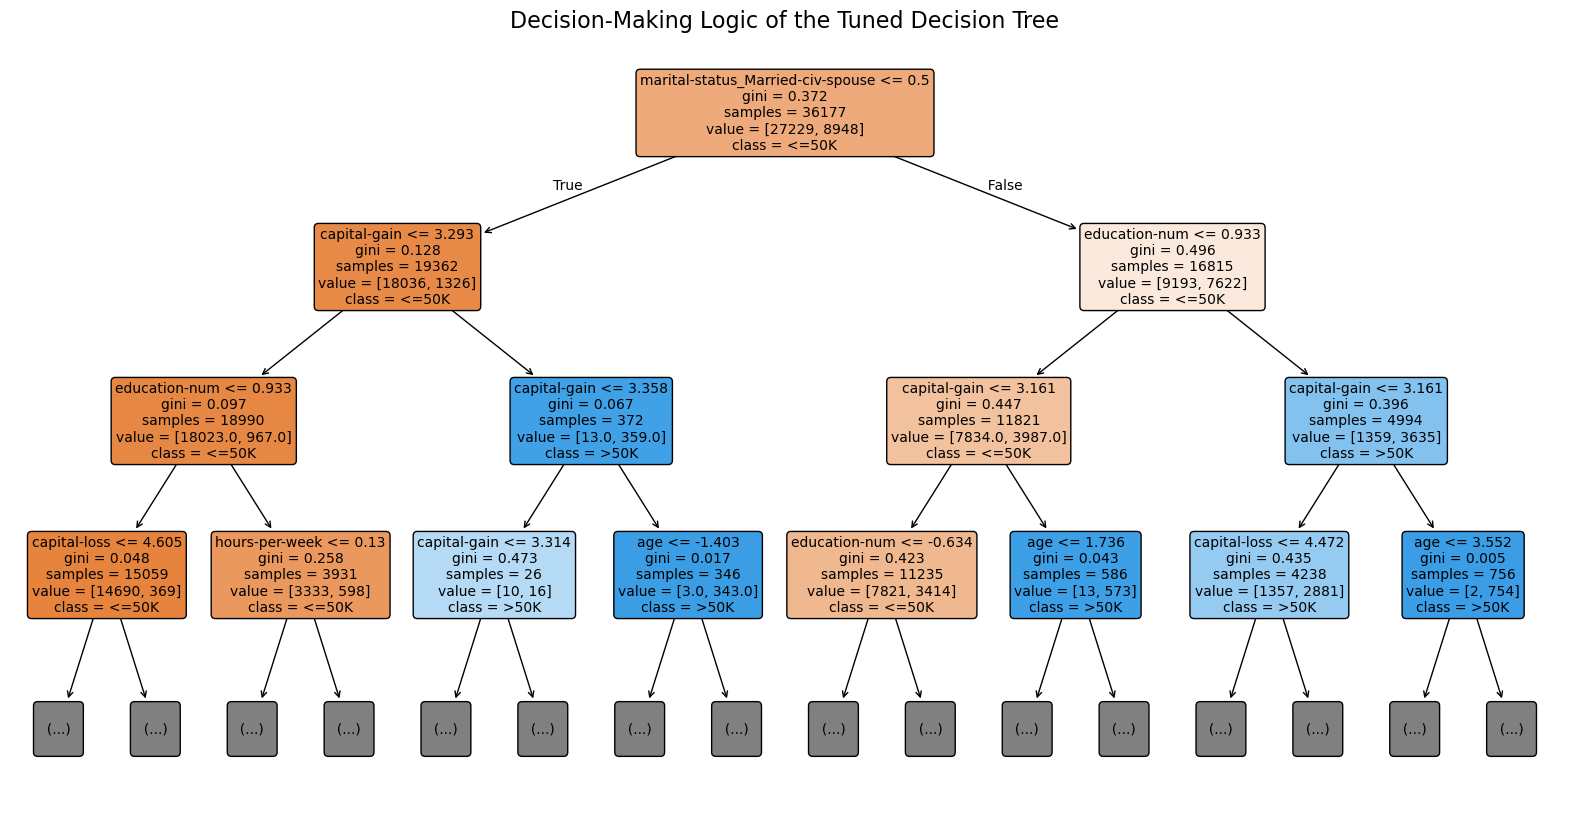

In [85]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# We use the 'best_dt_model' we trained after Hyperparameter Tuning
plt.figure(figsize=(20, 10))

plot_tree(best_dt_model, 
          feature_names=X.columns, 
          class_names=['<=50K', '>50K'], 
          filled=True, 
          rounded=True, 
          fontsize=10, 
          max_depth=3) 

plt.title("Decision-Making Logic of the Tuned Decision Tree", fontsize=16)
plt.show()

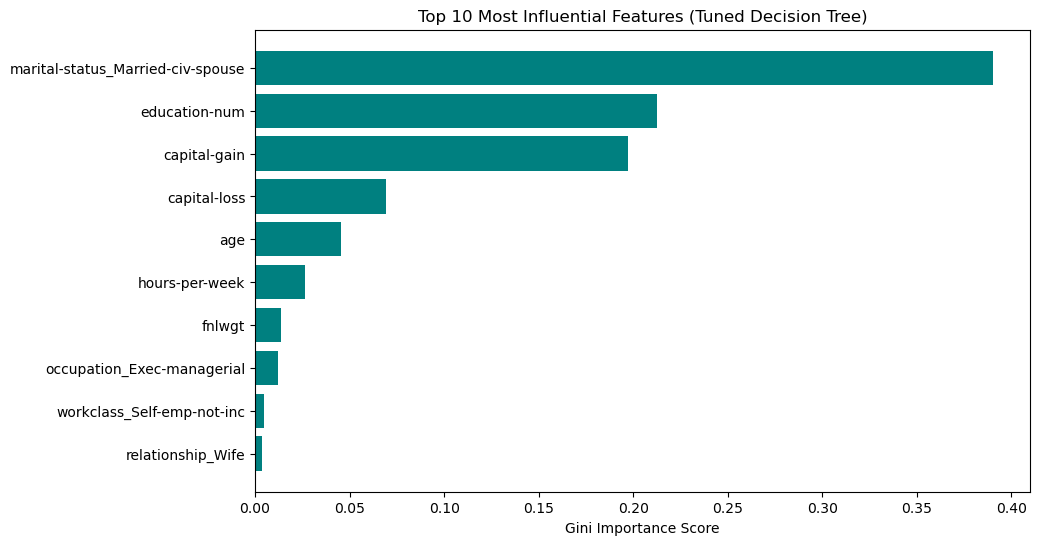

In [86]:
import numpy as np

# Extract importance scores from the tuned model
importances = best_dt_model.feature_importances_

# Organize into a DataFrame and sort for a horizontal bar plot
feat_import_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_import_df = feat_import_df.sort_values(by='Importance', ascending=True).tail(10)

plt.figure(figsize=(10, 6))
plt.barh(feat_import_df['Feature'], feat_import_df['Importance'], color='teal')
plt.xlabel("Gini Importance Score")
plt.title("Top 10 Most Influential Features (Tuned Decision Tree)")
plt.show()

In [87]:
import pandas as pd

# Final Summary Table
final_comparison = pd.DataFrame({
    "Model Stage": ["Initial Decision Tree", "Random Forest", "XGBoost", "Tuned Decision Tree"],
    "Accuracy": ["84.43%", "85.19%", "86.62%", "85.14%"]
})

display(final_comparison)

,Model Stage,Accuracy
0,Initial Decision Tree,84.43%
1,Random Forest,85.19%
2,XGBoost,86.62%
3,Tuned Decision Tree,85.14%


In [88]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


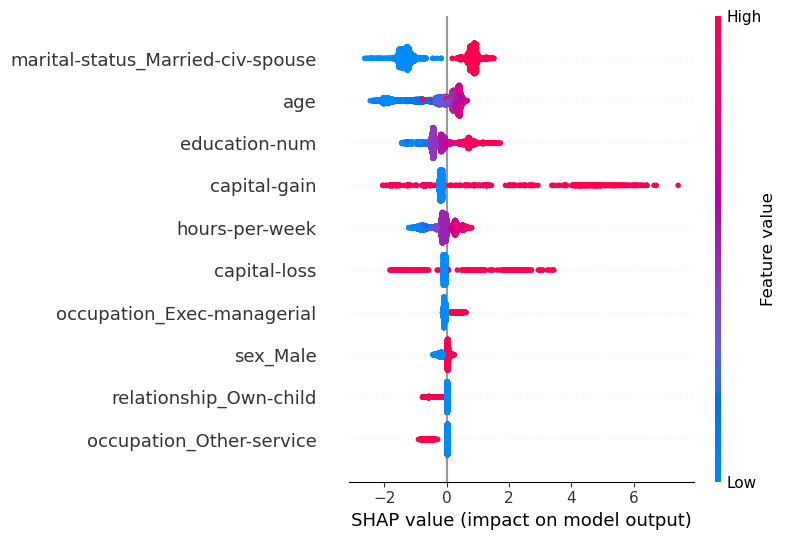

In [89]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the SHAP TreeExplainer for XGBoost
# This tool helps us "see inside" the complex XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# 2. Calculate SHAP values for the test set
# This measures how much each feature pushed the income guess up or down
shap_values = explainer.shap_values(X_test)

# 3. Create a Summary Plot (Limited to Top 10)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, max_display=10)

CONCLUSION:
Our analysis proved that while a single Decision Tree is easy to visualize, it struggles to find all high-income individuals (low Recall). By moving to Ensemblage Methods like Random Forest and XGBoost, we significantly improved our results. XGBoost emerged as the most powerful model, showing that learning from errors sequentially is the best strategy for this dataset. Finally, using SHAP confirmed that Marital Status and Age are the most influential factors in determining income level in this census data.